In [200]:
# imports
import os
from packaging import version
import shutil

import pandas as pd
import tensorboard as tb

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# check tensorboard version
major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
    'This notebook requires TensorBoard 2.3 or later.'
print("TensorBoard version: ", tb.__version__)

In [294]:
# copy relevant model metrics into seperate folder and upload to tensorboard dev
data_filter = 'test' # 'train', 'test' or 'validation'
model_filter = 'resnet'# 'basic' or 'resnet'
log_path = '../logs/scalars'
upload_path = '../tensorboard_upload/'
os.mkdir(upload_path)

for (dirpath, dirnames, filenames) in os.walk(log_path):
    # filter dirs
    if data_filter in dirpath and model_filter in dirpath:

        from_directory = dirpath
        to_directory = upload_path + dirpath[16:]

        # copy dir trees
        shutil.copytree(from_directory, to_directory)

# TODO: run in project root
print(f'tensorboard dev upload --logdir=./tensorboard_upload/ --name FLE_{model_filter}_{data_filter}')

tensorboard dev upload --logdir=./tensorboard_upload/ --name FLE_resnet_test


In [317]:
# remove copied dir trees
shutil.rmtree(upload_path)

In [269]:
# TODO: set tensorboard dev ID
experiment_ids = ['6QQYimtjSoK55Q6f7v5Pyg', 'Qm4QcX0MTvSAOFvJrBf19Q']
all_dfs = []

# download experiment
for ind, id in enumerate(experiment_ids):
    experiment = tb.data.experimental.ExperimentFromDev(id)
    df_temp = experiment.get_scalars()
    
    print(f'{ind}: {df_temp.shape}')
    all_dfs.append(df_temp)

df = all_dfs[0]

if len(all_dfs) > 1:
    for new_df in all_dfs[1:]:
        df = pd.concat([df, new_df])

print(df.shape)
df.head()

0: (1780000, 4)
1: (1779925, 4)
(3559925, 4)


,run,tag,step,value
0,basic_00000r_14c\20220413-1643\test,batch_accuracy,1,0.000000
1,basic_00000r_14c\20220413-1643\test,batch_accuracy,2,0.093750
2,basic_00000r_14c\20220413-1643\test,batch_accuracy,3,0.156250
3,basic_00000r_14c\20220413-1643\test,batch_accuracy,4,0.164062
4,basic_00000r_14c\20220413-1643\test,batch_accuracy,5,0.175000


In [270]:
# extract features
df['model'] = df['run'].str.extract('(^[a-z]{5,6})_')
df['data'] = df['run'].str.extract('([a-z]{4,})$')
df['ratio'] = df['run'].str.extract('(\d{5})r').astype(float)
df['ratio'] = df['ratio'] / 100
df['classes'] = df['run'].str.extract('(\d{1,2})c')

In [272]:
print(df.columns)
print(df.shape)
print(len(df['run'].unique()))
# print(df["tag"].unique())
df.head()

Index(['run', 'tag', 'step', 'value', 'model', 'data', 'ratio', 'classes'], dtype='object')
(3559925, 8)
200


,run,tag,step,value,model,data,ratio,classes
0,basic_00000r_14c\20220413-1643\test,batch_accuracy,1,0.000000,basic,test,0.0,14
1,basic_00000r_14c\20220413-1643\test,batch_accuracy,2,0.093750,basic,test,0.0,14
2,basic_00000r_14c\20220413-1643\test,batch_accuracy,3,0.156250,basic,test,0.0,14
3,basic_00000r_14c\20220413-1643\test,batch_accuracy,4,0.164062,basic,test,0.0,14
4,basic_00000r_14c\20220413-1643\test,batch_accuracy,5,0.175000,basic,test,0.0,14


In [280]:
# TODO: change csv file name
df.to_csv('../logs/fle_testMetrics_raw.csv', index=False)

------------

#### accuracy plot

In [295]:
df_epoch_accuracy = df.query("tag == 'epoch_accuracy' & step == 19 & run.str.contains('test')")
df_epoch_accuracy = df_epoch_accuracy.groupby(['model', 'classes', 'ratio', 'data', 'tag']).mean().reset_index()
df_epoch_accuracy.head()

,model,classes,ratio,data,tag,step,value
0,basic,14,0.00,test,epoch_accuracy,19.0,0.845858
1,basic,14,0.25,test,epoch_accuracy,19.0,0.832078
2,basic,14,0.50,test,epoch_accuracy,19.0,0.841190
3,basic,14,1.00,test,epoch_accuracy,19.0,0.823117
4,basic,14,2.00,test,epoch_accuracy,19.0,0.820331


In [296]:
df_epoch_accuracy.query("model == 'resnet' & classes == '4' & ratio > 5")

,model,classes,ratio,data,tag,step,value
38,resnet,4,7.5,test,epoch_accuracy,19.0,0.866943


TypeError: 'str' object is not callable

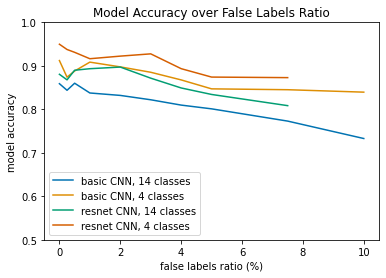

In [321]:
df_hue = df_epoch_accuracy[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

acc_plot = sns.lineplot(
            data=df_epoch_accuracy,
            x='ratio',
            y='value',
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model accuracy',
            ylim=(0.5,1),
            title='Model Accuracy over False Labels Ratio'
        )

------------

#### weighted avg precision plot

In [300]:
df_epoch_precision_w = df.query("tag == 'epoch_precision_weighted' & step == 19 & run.str.contains('test')")
df_epoch_precision_w = df_epoch_precision_w.groupby(['model', 'classes', 'ratio', 'data', 'tag']).mean().reset_index()
df_epoch_precision_w.head()

,model,classes,ratio,data,tag,step,value
0,basic,14,0.00,test,epoch_precision_weighted,19.0,0.858955
1,basic,14,0.25,test,epoch_precision_weighted,19.0,0.843824
2,basic,14,0.50,test,epoch_precision_weighted,19.0,0.860047
3,basic,14,1.00,test,epoch_precision_weighted,19.0,0.837603
4,basic,14,2.00,test,epoch_precision_weighted,19.0,0.832011


[Text(0.5, 0, 'false labels ratio (%)'),
 Text(0, 0.5, 'model precision (weighted)'),
 (0.5, 1.0),
 Text(0.5, 1.0, 'Model Precision (weighted) over False Labels Ratio')]

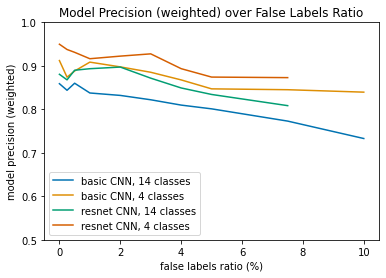

In [302]:
df_hue = df_epoch_precision_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.lineplot(
            data=df_epoch_precision_w,
            x='ratio',
            y='value',
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model precision (weighted)',
            ylim=(0.5,1),
            title='Model Precision (weighted) over False Labels Ratio'
        )

In [ ]:
plt.savefig('fle_precision_fl-ratio.png')

------------

#### weighted avg recall plot

In [304]:
df_epoch_recall_w = df.query("tag == 'epoch_recall_weighted' & step == 19 & run.str.contains('test')")
df_epoch_recall_w = df_epoch_recall_w.groupby(['model', 'classes', 'ratio', 'data', 'tag']).mean().reset_index()
df_epoch_recall_w.head()

,model,classes,ratio,data,tag,step,value
0,basic,14,0.00,test,epoch_recall_weighted,19.0,0.845858
1,basic,14,0.25,test,epoch_recall_weighted,19.0,0.832078
2,basic,14,0.50,test,epoch_recall_weighted,19.0,0.841190
3,basic,14,1.00,test,epoch_recall_weighted,19.0,0.823117
4,basic,14,2.00,test,epoch_recall_weighted,19.0,0.820331


[Text(0.5, 0, 'false labels ratio (%)'),
 Text(0, 0.5, 'model recall (weighted)'),
 (0.5, 1.0),
 Text(0.5, 1.0, 'Model Recall (weighted) over False Labels Ratio')]

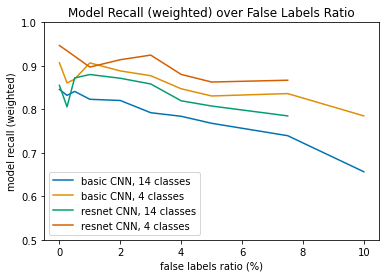

In [305]:
df_hue = df_epoch_recall_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.lineplot(
            data=df_epoch_recall_w,
            x='ratio',
            y='value',
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model recall (weighted)',
            ylim=(0.5,1),
            title='Model Recall (weighted) over False Labels Ratio'
        )

In [ ]:
plt.savefig('fle_recall_fl-ratio.png')

------------

#### weighted avg f1-score plot

In [306]:
df_epoch_f1score_w = df.query("tag == 'epoch_f1-score_weighted' & step == 19 & run.str.contains('test')")
df_epoch_f1score_w = df_epoch_f1score_w.groupby(['model', 'classes', 'ratio', 'data', 'tag']).mean().reset_index()
df_epoch_f1score_w.head()

,model,classes,ratio,data,tag,step,value
0,basic,14,0.00,test,epoch_f1-score_weighted,19.0,0.846319
1,basic,14,0.25,test,epoch_f1-score_weighted,19.0,0.831295
2,basic,14,0.50,test,epoch_f1-score_weighted,19.0,0.838249
3,basic,14,1.00,test,epoch_f1-score_weighted,19.0,0.820368
4,basic,14,2.00,test,epoch_f1-score_weighted,19.0,0.819614


[Text(0.5, 0, 'false labels ratio (%)'),
 Text(0, 0.5, 'model f1-score (weighted)'),
 (0.5, 1.0),
 Text(0.5, 1.0, 'Model f1-score (weighted) over False Labels Ratio')]

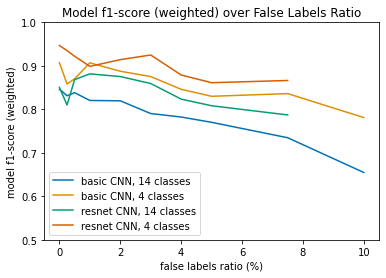

In [308]:
df_hue = df_epoch_f1score_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.lineplot(
            data=df_epoch_f1score_w,
            x='ratio',
            y='value',
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model f1-score (weighted)',
            ylim=(0.5,1),
            title='Model f1-score (weighted) over False Labels Ratio'
        )

In [ ]:
plt.savefig('fle_f1-score_fl-ratio.png')